In [1]:
!pip install torchinfo

In [2]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

In [3]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


In [4]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:
data_dir = "/kaggle/input/fish-ra"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: Tarabaim, Count: 2500
Class: Shol, Count: 2500
Class: Puti, Count: 2500
Class: DeshiPuti, Count: 2500
Class: Aair, Count: 2500
Class: Tengra, Count: 2500
Class: Pabda, Count: 2500
Class: Foli, Count: 2500
Class: Katla, Count: 2500
Class: Ilish, Count: 2500
Class: Taki, Count: 2500
Class: KalBaush, Count: 2500
Class: Chapila, Count: 2500
Class: Magur, Count: 2500
Class: Pangas, Count: 2500
Class: Mrigel, Count: 2500
Class: Telapiya, Count: 2500
Class: Koi, Count: 2500
Class: Boal, Count: 2500
Class: Rui, Count: 2500


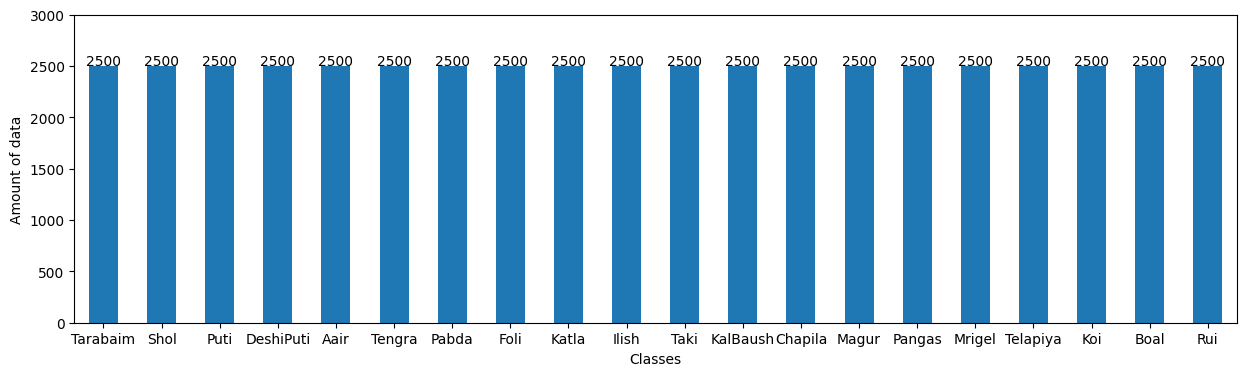

In [6]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(15, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

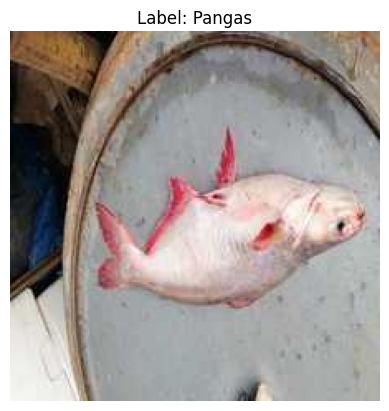

In [7]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [8]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [9]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  35000
Validation Data:  7500
Test Data:  7500
-------------------------------------------
Total amounts of data in the dataset:  50000


In [10]:
class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class        Count
---------  -------
Katla         1750
Tengra        1750
Shol          1750
DeshiPuti     1750
Koi           1750
Pabda         1750
Pangas        1750
Aair          1750
Ilish         1750
Boal          1750
Magur         1750
Tarabaim      1750
Foli          1750
Mrigel        1750
KalBaush      1750
Taki          1750
Telapiya      1750
Rui           1750
Chapila       1750
Puti          1750

Validation Dataset
Class        Count
---------  -------
Shol           375
Taki           375
Koi            375
DeshiPuti      375
Pangas         375
Aair           375
Rui            375
Katla          375
Ilish          375
Magur          375
Chapila        375
Boal           375
Telapiya       375
Foli           375
Puti           375
Tarabaim       375
Mrigel         375
Pabda          375
KalBaush       375
Tengra         375

Test Dataset
Class        Count
---------  -------
Foli           375
Telapiya       375
Koi            375
Taki           375
Te

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        class_names = sorted(self.dataframe['label'].unique())  
        self.label_map = {class_name: idx for idx, class_name in enumerate(class_names)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [13]:
normalize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = ImageDataset(train_dataframe, normalize, is_lb=True)
print(train_dataset.label_map)

{'Aair': 0, 'Boal': 1, 'Chapila': 2, 'DeshiPuti': 3, 'Foli': 4, 'Ilish': 5, 'KalBaush': 6, 'Katla': 7, 'Koi': 8, 'Magur': 9, 'Mrigel': 10, 'Pabda': 11, 'Pangas': 12, 'Puti': 13, 'Rui': 14, 'Shol': 15, 'Taki': 16, 'Tarabaim': 17, 'Telapiya': 18, 'Tengra': 19}


In [14]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

In [15]:
train_batch = 32
val_batch = 8

def data_transfrom():
    normalize = transforms.Compose([
            
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])

    train_dataset = ImageDataset (
        train_dataframe,
        normalize,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

In [16]:
import torch.nn as nn

class FishNet(nn.Module):
    def __init__(self, num_classes):
        super(FishNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),     
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                 

            nn.Conv2d(32, 64, 3, padding=1),    
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                 

            nn.Conv2d(64, 128, 3, padding=1),   
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                 

            nn.Conv2d(128, 256, 3, padding=1),  
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                 
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                     
            nn.Linear(256 * 14 * 14, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [17]:
model = FishNet(num_classes=20).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [18]:
import time
import torch
from tqdm.notebook import tqdm
import pandas as pd
import os

start_time = time.time()
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=100, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    best_val_acc = 0.0

    
    os.makedirs(save_path_checkpoints, exist_ok=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total

        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for val_images, val_labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)

                val_loss += loss.item() * val_images.size(0)
                _, val_preds = torch.max(val_outputs, 1)
                val_correct += (val_preds == val_labels).sum().item()
                val_total += val_labels.size(0)

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total

        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

     
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save({
                'epoch': epoch,
                'model_weight': model.state_dict(),
                'optimizer_state': optimizer.state_dict()
            }, f"{save_path_checkpoints}/model.pt")

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

    elapsed = time.time() - start_time
    print(f"\nTraining complete in {elapsed//60:.0f}m {elapsed%60:.0f}s")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model, criterion, optimizer,
    dataloader_train_dataset, dataloader_valid_dataset,
    num_epochs=100,
    save_path_checkpoints="checkpoints"
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")


data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 1/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/100 | Train Loss: 1.5216 | Train Acc: 0.5194 | Val Loss: 0.5387 | Val Acc: 0.8343


Epoch 2/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 2/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/100 | Train Loss: 0.7273 | Train Acc: 0.7654 | Val Loss: 0.3750 | Val Acc: 0.8835


Epoch 3/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 3/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/100 | Train Loss: 0.5044 | Train Acc: 0.8377 | Val Loss: 0.2350 | Val Acc: 0.9247


Epoch 4/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 4/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/100 | Train Loss: 0.3782 | Train Acc: 0.8785 | Val Loss: 0.2392 | Val Acc: 0.9213


Epoch 5/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 5/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/100 | Train Loss: 0.3165 | Train Acc: 0.8978 | Val Loss: 0.1464 | Val Acc: 0.9539


Epoch 6/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 6/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/100 | Train Loss: 0.2717 | Train Acc: 0.9107 | Val Loss: 0.1434 | Val Acc: 0.9535


Epoch 7/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 7/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/100 | Train Loss: 0.2249 | Train Acc: 0.9275 | Val Loss: 0.1311 | Val Acc: 0.9576


Epoch 8/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 8/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/100 | Train Loss: 0.1997 | Train Acc: 0.9347 | Val Loss: 0.1068 | Val Acc: 0.9651


Epoch 9/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 9/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/100 | Train Loss: 0.1883 | Train Acc: 0.9407 | Val Loss: 0.1030 | Val Acc: 0.9657


Epoch 10/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 10/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/100 | Train Loss: 0.1629 | Train Acc: 0.9464 | Val Loss: 0.0912 | Val Acc: 0.9713


Epoch 11/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 11/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 11/100 | Train Loss: 0.1463 | Train Acc: 0.9521 | Val Loss: 0.0891 | Val Acc: 0.9708


Epoch 12/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 12/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12/100 | Train Loss: 0.1393 | Train Acc: 0.9546 | Val Loss: 0.0872 | Val Acc: 0.9739


Epoch 13/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 13/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13/100 | Train Loss: 0.1237 | Train Acc: 0.9598 | Val Loss: 0.0838 | Val Acc: 0.9732


Epoch 14/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 14/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14/100 | Train Loss: 0.1172 | Train Acc: 0.9611 | Val Loss: 0.0826 | Val Acc: 0.9741


Epoch 15/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 15/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 15/100 | Train Loss: 0.1059 | Train Acc: 0.9655 | Val Loss: 0.1011 | Val Acc: 0.9701


Epoch 16/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 16/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 16/100 | Train Loss: 0.1039 | Train Acc: 0.9656 | Val Loss: 0.0960 | Val Acc: 0.9699


Epoch 17/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 17/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 17/100 | Train Loss: 0.0934 | Train Acc: 0.9704 | Val Loss: 0.0845 | Val Acc: 0.9721


Epoch 18/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 18/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 18/100 | Train Loss: 0.0923 | Train Acc: 0.9697 | Val Loss: 0.0680 | Val Acc: 0.9773


Epoch 19/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 19/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 19/100 | Train Loss: 0.0877 | Train Acc: 0.9723 | Val Loss: 0.0972 | Val Acc: 0.9720


Epoch 20/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 20/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 20/100 | Train Loss: 0.0870 | Train Acc: 0.9717 | Val Loss: 0.0807 | Val Acc: 0.9783


Epoch 21/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 21/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 21/100 | Train Loss: 0.0756 | Train Acc: 0.9751 | Val Loss: 0.0809 | Val Acc: 0.9743


Epoch 22/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 22/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 22/100 | Train Loss: 0.0761 | Train Acc: 0.9759 | Val Loss: 0.0870 | Val Acc: 0.9739


Epoch 23/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 23/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 23/100 | Train Loss: 0.0749 | Train Acc: 0.9749 | Val Loss: 0.0780 | Val Acc: 0.9763


Epoch 24/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 24/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 24/100 | Train Loss: 0.0679 | Train Acc: 0.9772 | Val Loss: 0.0870 | Val Acc: 0.9764


Epoch 25/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 25/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 25/100 | Train Loss: 0.0680 | Train Acc: 0.9784 | Val Loss: 0.0748 | Val Acc: 0.9772


Epoch 26/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 26/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 26/100 | Train Loss: 0.0598 | Train Acc: 0.9804 | Val Loss: 0.0743 | Val Acc: 0.9795


Epoch 27/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 27/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 27/100 | Train Loss: 0.0641 | Train Acc: 0.9791 | Val Loss: 0.0688 | Val Acc: 0.9796


Epoch 28/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 28/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 28/100 | Train Loss: 0.0658 | Train Acc: 0.9791 | Val Loss: 0.0920 | Val Acc: 0.9733


Epoch 29/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 29/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 29/100 | Train Loss: 0.0540 | Train Acc: 0.9827 | Val Loss: 0.0719 | Val Acc: 0.9807


Epoch 30/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 30/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 30/100 | Train Loss: 0.0538 | Train Acc: 0.9827 | Val Loss: 0.0755 | Val Acc: 0.9793


Epoch 31/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 31/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 31/100 | Train Loss: 0.0514 | Train Acc: 0.9832 | Val Loss: 0.0811 | Val Acc: 0.9755


Epoch 32/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 32/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 32/100 | Train Loss: 0.0550 | Train Acc: 0.9828 | Val Loss: 0.0773 | Val Acc: 0.9799


Epoch 33/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 33/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 33/100 | Train Loss: 0.0483 | Train Acc: 0.9843 | Val Loss: 0.0686 | Val Acc: 0.9809


Epoch 34/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 34/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 34/100 | Train Loss: 0.0518 | Train Acc: 0.9835 | Val Loss: 0.0958 | Val Acc: 0.9747


Epoch 35/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 35/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 35/100 | Train Loss: 0.0442 | Train Acc: 0.9858 | Val Loss: 0.0812 | Val Acc: 0.9797


Epoch 36/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 36/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 36/100 | Train Loss: 0.0521 | Train Acc: 0.9829 | Val Loss: 0.0829 | Val Acc: 0.9789


Epoch 37/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 37/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 37/100 | Train Loss: 0.0470 | Train Acc: 0.9853 | Val Loss: 0.1061 | Val Acc: 0.9672


Epoch 38/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 38/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 38/100 | Train Loss: 0.0442 | Train Acc: 0.9859 | Val Loss: 0.0755 | Val Acc: 0.9804


Epoch 39/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 39/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 39/100 | Train Loss: 0.0452 | Train Acc: 0.9859 | Val Loss: 0.0775 | Val Acc: 0.9809


Epoch 40/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 40/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 40/100 | Train Loss: 0.0481 | Train Acc: 0.9851 | Val Loss: 0.0643 | Val Acc: 0.9815


Epoch 41/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 41/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 41/100 | Train Loss: 0.0384 | Train Acc: 0.9876 | Val Loss: 0.0698 | Val Acc: 0.9823


Epoch 42/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 42/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 42/100 | Train Loss: 0.0434 | Train Acc: 0.9862 | Val Loss: 0.0787 | Val Acc: 0.9780


Epoch 43/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 43/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 43/100 | Train Loss: 0.0426 | Train Acc: 0.9867 | Val Loss: 0.0760 | Val Acc: 0.9799


Epoch 44/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 44/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 44/100 | Train Loss: 0.0418 | Train Acc: 0.9871 | Val Loss: 0.0800 | Val Acc: 0.9783


Epoch 45/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 45/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 45/100 | Train Loss: 0.0371 | Train Acc: 0.9887 | Val Loss: 0.0679 | Val Acc: 0.9820


Epoch 46/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 46/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 46/100 | Train Loss: 0.0381 | Train Acc: 0.9879 | Val Loss: 0.0703 | Val Acc: 0.9812


Epoch 47/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 47/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 47/100 | Train Loss: 0.0404 | Train Acc: 0.9875 | Val Loss: 0.0627 | Val Acc: 0.9829


Epoch 48/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 48/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 48/100 | Train Loss: 0.0367 | Train Acc: 0.9883 | Val Loss: 0.0764 | Val Acc: 0.9799


Epoch 49/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 49/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 49/100 | Train Loss: 0.0343 | Train Acc: 0.9888 | Val Loss: 0.0688 | Val Acc: 0.9824


Epoch 50/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 50/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 50/100 | Train Loss: 0.0314 | Train Acc: 0.9896 | Val Loss: 0.0687 | Val Acc: 0.9824


Epoch 51/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 51/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 51/100 | Train Loss: 0.0349 | Train Acc: 0.9890 | Val Loss: 0.0752 | Val Acc: 0.9827


Epoch 52/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 52/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 52/100 | Train Loss: 0.0354 | Train Acc: 0.9891 | Val Loss: 0.0767 | Val Acc: 0.9805


Epoch 53/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 53/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 53/100 | Train Loss: 0.0325 | Train Acc: 0.9901 | Val Loss: 0.0644 | Val Acc: 0.9815


Epoch 54/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 54/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 54/100 | Train Loss: 0.0292 | Train Acc: 0.9910 | Val Loss: 0.0792 | Val Acc: 0.9819


Epoch 55/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 55/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 55/100 | Train Loss: 0.0313 | Train Acc: 0.9897 | Val Loss: 0.0789 | Val Acc: 0.9815


Epoch 56/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 56/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 56/100 | Train Loss: 0.0356 | Train Acc: 0.9894 | Val Loss: 0.0694 | Val Acc: 0.9831


Epoch 57/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 57/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 57/100 | Train Loss: 0.0284 | Train Acc: 0.9911 | Val Loss: 0.0769 | Val Acc: 0.9812


Epoch 58/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 58/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 58/100 | Train Loss: 0.0262 | Train Acc: 0.9917 | Val Loss: 0.0764 | Val Acc: 0.9828


Epoch 59/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 59/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 59/100 | Train Loss: 0.0301 | Train Acc: 0.9903 | Val Loss: 0.0866 | Val Acc: 0.9804


Epoch 60/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 60/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 60/100 | Train Loss: 0.0265 | Train Acc: 0.9912 | Val Loss: 0.0652 | Val Acc: 0.9833


Epoch 61/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 61/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 61/100 | Train Loss: 0.0282 | Train Acc: 0.9914 | Val Loss: 0.0756 | Val Acc: 0.9800


Epoch 62/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 62/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 62/100 | Train Loss: 0.0284 | Train Acc: 0.9909 | Val Loss: 0.0772 | Val Acc: 0.9819


Epoch 63/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 63/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 63/100 | Train Loss: 0.0294 | Train Acc: 0.9901 | Val Loss: 0.0793 | Val Acc: 0.9811


Epoch 64/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 64/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 64/100 | Train Loss: 0.0279 | Train Acc: 0.9915 | Val Loss: 0.0724 | Val Acc: 0.9835


Epoch 65/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 65/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 65/100 | Train Loss: 0.0274 | Train Acc: 0.9915 | Val Loss: 0.0891 | Val Acc: 0.9781


Epoch 66/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 66/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 66/100 | Train Loss: 0.0333 | Train Acc: 0.9907 | Val Loss: 0.0712 | Val Acc: 0.9820


Epoch 67/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 67/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 67/100 | Train Loss: 0.0255 | Train Acc: 0.9922 | Val Loss: 0.0712 | Val Acc: 0.9811


Epoch 68/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 68/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 68/100 | Train Loss: 0.0271 | Train Acc: 0.9917 | Val Loss: 0.0720 | Val Acc: 0.9820


Epoch 69/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 69/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 69/100 | Train Loss: 0.0234 | Train Acc: 0.9929 | Val Loss: 0.0759 | Val Acc: 0.9815


Epoch 70/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 70/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 70/100 | Train Loss: 0.0257 | Train Acc: 0.9920 | Val Loss: 0.0731 | Val Acc: 0.9820


Epoch 71/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 71/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 71/100 | Train Loss: 0.0268 | Train Acc: 0.9920 | Val Loss: 0.0855 | Val Acc: 0.9813


Epoch 72/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 72/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 72/100 | Train Loss: 0.0253 | Train Acc: 0.9923 | Val Loss: 0.0638 | Val Acc: 0.9829


Epoch 73/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 73/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 73/100 | Train Loss: 0.0234 | Train Acc: 0.9925 | Val Loss: 0.0803 | Val Acc: 0.9807


Epoch 74/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 74/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 74/100 | Train Loss: 0.0258 | Train Acc: 0.9925 | Val Loss: 0.0668 | Val Acc: 0.9813


Epoch 75/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 75/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 75/100 | Train Loss: 0.0297 | Train Acc: 0.9916 | Val Loss: 0.0646 | Val Acc: 0.9845


Epoch 76/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 76/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 76/100 | Train Loss: 0.0184 | Train Acc: 0.9943 | Val Loss: 0.0674 | Val Acc: 0.9839


Epoch 77/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 77/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 77/100 | Train Loss: 0.0226 | Train Acc: 0.9932 | Val Loss: 0.0645 | Val Acc: 0.9847


Epoch 78/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 78/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 78/100 | Train Loss: 0.0244 | Train Acc: 0.9929 | Val Loss: 0.0741 | Val Acc: 0.9811


Epoch 79/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 79/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 79/100 | Train Loss: 0.0219 | Train Acc: 0.9936 | Val Loss: 0.0732 | Val Acc: 0.9824


Epoch 80/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 80/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 80/100 | Train Loss: 0.0210 | Train Acc: 0.9933 | Val Loss: 0.0834 | Val Acc: 0.9816


Epoch 81/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 81/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 81/100 | Train Loss: 0.0245 | Train Acc: 0.9930 | Val Loss: 0.0637 | Val Acc: 0.9829


Epoch 82/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 82/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 82/100 | Train Loss: 0.0228 | Train Acc: 0.9931 | Val Loss: 0.0737 | Val Acc: 0.9833


Epoch 83/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 83/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 83/100 | Train Loss: 0.0245 | Train Acc: 0.9931 | Val Loss: 0.0625 | Val Acc: 0.9837


Epoch 84/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 84/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 84/100 | Train Loss: 0.0182 | Train Acc: 0.9947 | Val Loss: 0.0664 | Val Acc: 0.9837


Epoch 85/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 85/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 85/100 | Train Loss: 0.0212 | Train Acc: 0.9939 | Val Loss: 0.0765 | Val Acc: 0.9808


Epoch 86/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 86/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 86/100 | Train Loss: 0.0211 | Train Acc: 0.9936 | Val Loss: 0.0665 | Val Acc: 0.9829


Epoch 87/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 87/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 87/100 | Train Loss: 0.0225 | Train Acc: 0.9933 | Val Loss: 0.0649 | Val Acc: 0.9841


Epoch 88/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 88/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 88/100 | Train Loss: 0.0221 | Train Acc: 0.9939 | Val Loss: 0.0648 | Val Acc: 0.9835


Epoch 89/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 89/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 89/100 | Train Loss: 0.0226 | Train Acc: 0.9939 | Val Loss: 0.0700 | Val Acc: 0.9833


Epoch 90/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 90/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 90/100 | Train Loss: 0.0172 | Train Acc: 0.9945 | Val Loss: 0.0958 | Val Acc: 0.9800


Epoch 91/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 91/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 91/100 | Train Loss: 0.0184 | Train Acc: 0.9940 | Val Loss: 0.0911 | Val Acc: 0.9805


Epoch 92/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 92/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 92/100 | Train Loss: 0.0230 | Train Acc: 0.9932 | Val Loss: 0.0813 | Val Acc: 0.9817


Epoch 93/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 93/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 93/100 | Train Loss: 0.0186 | Train Acc: 0.9942 | Val Loss: 0.0750 | Val Acc: 0.9840


Epoch 94/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 94/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 94/100 | Train Loss: 0.0180 | Train Acc: 0.9947 | Val Loss: 0.0818 | Val Acc: 0.9829


Epoch 95/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 95/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 95/100 | Train Loss: 0.0221 | Train Acc: 0.9933 | Val Loss: 0.0708 | Val Acc: 0.9832


Epoch 96/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 96/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 96/100 | Train Loss: 0.0195 | Train Acc: 0.9943 | Val Loss: 0.0779 | Val Acc: 0.9815


Epoch 97/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 97/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 97/100 | Train Loss: 0.0183 | Train Acc: 0.9940 | Val Loss: 0.0709 | Val Acc: 0.9843


Epoch 98/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 98/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 98/100 | Train Loss: 0.0187 | Train Acc: 0.9943 | Val Loss: 0.0614 | Val Acc: 0.9857


Epoch 99/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 99/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 99/100 | Train Loss: 0.0182 | Train Acc: 0.9944 | Val Loss: 0.0718 | Val Acc: 0.9820


Epoch 100/100 - Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 100/100 - Validation:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 100/100 | Train Loss: 0.0202 | Train Acc: 0.9941 | Val Loss: 0.0744 | Val Acc: 0.9837

Training complete in 143m 58s
Best Validation Accuracy: 0.9857
Training Time: 8637.64 seconds ---> 143.96 minutes


# Load the Best Trained Model

In [19]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(train_dataframe['label'].unique())  
model = FishNet(num_classes=num_classes).to(device)


checkpoint_path = "checkpoints/model.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_weight'])
model.eval()  

print("Best CNN model loaded for feature extraction.")

Best CNN model loaded for feature extraction.


# Add Feature Extraction Wrapper

In [20]:

import torch.nn as nn
from tqdm.notebook import tqdm
import numpy as np

class FishNetFeatures(nn.Module):
    def __init__(self, original_model):
        super(FishNetFeatures, self).__init__()
        self.features = original_model.features
    
        self.classifier_part = nn.Sequential(*list(original_model.classifier.children())[:-3])  

    def forward(self, x):
        x = self.features(x)
        x = self.classifier_part(x)
        return x


feature_extractor = FishNetFeatures(model).to(device)
feature_extractor.eval()
print(" Feature extractor ready: outputs 256-D features.")

 Feature extractor ready: outputs 256-D features.


# Extract Features from Train and Test Sets

In [21]:

def extract_features(extractor, data_loader, device):
    extractor.eval()
    features_list = []
    labels_list = []
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Extracting Features"):
            images = images.to(device)
            feats = extractor(images)  
            features_list.append(feats.cpu().numpy())
            labels_list.append(labels.numpy())
    return np.concatenate(features_list, axis=0), np.concatenate(labels_list, axis=0)

X_train_feats, y_train = extract_features(feature_extractor, dataloader_train_dataset, device)
X_test_feats, y_test = extract_features(feature_extractor, dataloader_test_dataset, device)

print(f"Train features shape: {X_train_feats.shape}")  
print(f"Test features shape:  {X_test_feats.shape}")
print(f"Train labels shape:   {y_train.shape}")

Extracting Features:   0%|          | 0/1094 [00:00<?, ?it/s]

Extracting Features:   0%|          | 0/938 [00:00<?, ?it/s]

Train features shape: (35000, 256)
Test features shape:  (7500, 256)
Train labels shape:   (35000,)


#  Train ML Classifiers (SVM, KNN, RF, XGBoost)

In [22]:

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feats)
X_test_scaled = scaler.transform(X_test_feats)

classifiers = {
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=100, eval_metric='mlogloss', random_state=42, n_jobs=-1)
}

results = []
y_pred_dict = {}
y_proba_dict = {}

for name, clf in classifiers.items():
    print(f"\n Training {name}...")
    start = time.time()
    
    
    if name == "SVM":
        clf.fit(X_train_feats, y_train)
        train_time = time.time() - start
      
        pred_start = time.time()
        y_pred = clf.predict(X_test_feats)
        y_proba = clf.predict_proba(X_test_feats)
        test_time = time.time() - pred_start
    else:
        clf.fit(X_train_scaled, y_train)
        train_time = time.time() - start
        
      
        pred_start = time.time()
        y_pred = clf.predict(X_test_scaled)
        y_proba = clf.predict_proba(X_test_scaled)
        test_time = time.time() - pred_start


    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    try:
        auc_score = roc_auc_score(y_test, y_proba, average='weighted', multi_class='ovr') if y_proba.shape[1] > 2 else roc_auc_score(y_test, y_proba[:, 1])
    except:
        auc_score = float('nan')

   
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "ROC-AUC": auc_score,
        "Train Time (s)": train_time,
        "Test Time (s)": test_time
    })
    y_pred_dict[name] = y_pred
    y_proba_dict[name] = y_proba

# Convert to DataFrame
results_df = pd.DataFrame(results)
print("\n All ML models trained and evaluated.")
results_df.round(4)


 Training SVM...

 Training KNN...

 Training Random Forest...

 Training XGBoost...

 All ML models trained and evaluated.


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Train Time (s),Test Time (s)
0,SVM,0.9821,0.9822,0.9821,0.9821,0.9998,23.0010,7.8753
1,KNN,0.9825,0.9826,0.9825,0.9825,0.9945,0.0056,4.2215
2,Random Forest,0.9808,0.9809,0.9808,0.9808,0.9996,15.1662,0.1450
3,XGBoost,0.9752,0.9754,0.9752,0.9752,0.9993,23.8052,0.0732


# Evaluate Baseline CNN for Comparison

In [23]:

model.eval()
cnn_preds = []
cnn_probs = []

with torch.no_grad():
    for images, labels in tqdm(dataloader_test_dataset, desc="Evaluating Baseline CNN"):
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        _, predicted = torch.max(outputs, 1)
        cnn_preds.extend(predicted.cpu().numpy())
        cnn_probs.extend(probs)

acc = accuracy_score(y_test, cnn_preds)
prec = precision_score(y_test, cnn_preds, average='weighted')
rec = recall_score(y_test, cnn_preds, average='weighted')
f1 = f1_score(y_test, cnn_preds, average='weighted')

try:
    cnn_auc = roc_auc_score(y_test, np.array(cnn_probs), average='weighted', multi_class='ovr') if cnn_probs[0].shape[0] > 2 else roc_auc_score(y_test, np.array(cnn_probs)[:, 1])
except:
    cnn_auc = float('nan')

baseline = pd.DataFrame([{
    "Model": "Baseline CNN",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1,
    "ROC-AUC": cnn_auc,
    "Train Time (s)": "N/A",
    "Test Time (s)": "N/A"
}])


final_results = pd.concat([baseline, results_df], ignore_index=True)
final_results.round(4)

Evaluating Baseline CNN:   0%|          | 0/938 [00:00<?, ?it/s]

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Train Time (s),Test Time (s)
0,Baseline CNN,0.9815,0.9816,0.9815,0.9815,0.9998,N/A,N/A
1,SVM,0.9821,0.9822,0.9821,0.9821,0.9998,23.001033,7.875268
2,KNN,0.9825,0.9826,0.9825,0.9825,0.9945,0.005609,4.221533
3,Random Forest,0.9808,0.9809,0.9808,0.9808,0.9996,15.166175,0.14503
4,XGBoost,0.9752,0.9754,0.9752,0.9752,0.9993,23.80517,0.073221


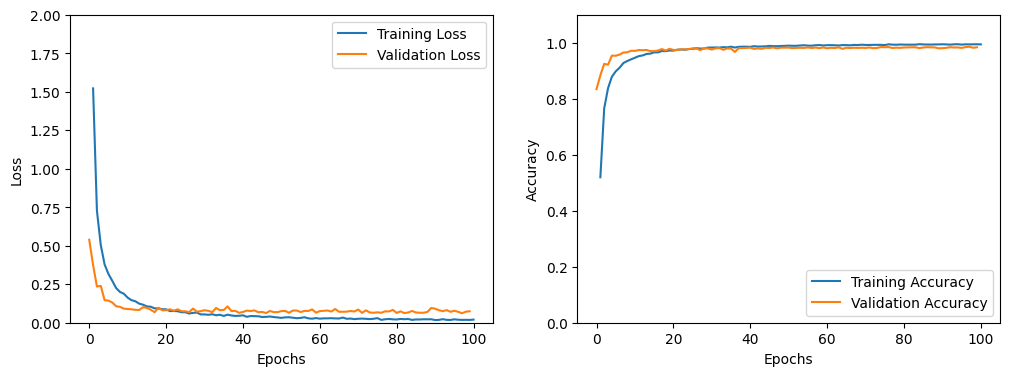

In [24]:
import pandas as pd
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

In [25]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [26]:
best_checkpoint_path = "checkpoints/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 97) - Validation Loss: 0.061, Validation Accuracy: 0.986


In [27]:
start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.981
Test Time: 10.75 seconds ---> 0.18 minutes


In [28]:
total_class = 20
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       375
           1       0.99      0.97      0.98       375
           2       0.98      1.00      0.99       375
           3       0.99      0.99      0.99       375
           4       0.99      0.99      0.99       375
           5       0.99      0.99      0.99       375
           6       0.97      0.98      0.97       375
           7       0.98      0.99      0.98       375
           8       0.99      0.99      0.99       375
           9       0.99      1.00      0.99       375
          10       0.99      0.98      0.99       375
          11       0.96      0.99      0.98       375
          12       0.99      1.00      1.00       375
          13       0.99      0.96      0.98       375
          14       0.99      0.97      0.98       375
          15       0.99      0.97      0.98       375
          16       0.93      0.94      0.94       375
    